In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from PIL import ImageCms

import pandas as pd
from tqdm.notebook import tqdm

In [ ]:
# fix random seed
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)

In [ ]:
class config:
  batch_size = 16*5
  criterion = nn.MSELoss()
  num_epochs = 40
  gradient_accumulation_steps = 1
  DataFilter_constant = 7

Load data




In [ ]:
!unzip -q /content/drive/MyDrive/dataset/archive.zip -d datasetn

In [ ]:
# dataset modes
DATA_MODES = ['train', 'val', 'test']
# all images will be scaled to the size of 224x224 px
RESCALE_SIZE = 224
# device setting
DEVICE = torch.device("cuda")

In [ ]:
ab1 = torch.tensor(np.load('/content/datasetn/ab/ab/ab1.npy'))
ab2 = torch.tensor(np.load('/content/datasetn/ab/ab/ab2.npy'))
ab3 = torch.tensor(np.load('/content/datasetn/ab/ab/ab3.npy'))

In [ ]:
ab = torch.cat((ab1, ab2,ab3))
del(ab1, ab2, ab3)
L = torch.tensor(np.load('/content/datasetn/l/gray_scale.npy'))

In [ ]:
def DataFilter(X,Y):
  good_id = []
  for i in tqdm(range(Y.shape[0])):
    if torch.std((Y[i].to(dtype=torch.float32)-128)) > config.DataFilter_constant:
      good_id.append(i)
  X = X[good_id]
  Y = Y[good_id]
  print(len(good_id))
  return X, Y

In [ ]:
L, ab = DataFilter(L, ab)

  0%|          | 0/25000 [00:00<?, ?it/s]

18584


In [ ]:
train_X = L[:(L.shape[0]-300)]
train_Y = ab[:(L.shape[0]-300)]
test_X = L[(L.shape[0]-300):]
test_Y = ab[(L.shape[0]-300):]
del(L, ab)

#Make statistics to normalize data




In [ ]:
train_Xf = train_X.to(dtype = torch.float32)
E_X = torch.mean(train_Xf)
D_X = torch.std(train_Xf)
del(train_Xf)
train_Yf = train_Y.to(dtype = torch.float32)
E_Y = torch.mean(train_Yf)
D_Y = torch.std(train_Yf)
del(train_Yf)

In [ ]:
print(D_Y)

tensor(19.1415)


# Dataset and DataLoader

In [ ]:
class MyDataset(Dataset):
  def __init__(self,X,Y,E_X,D_X,E_Y,D_Y):
    self.X = X.unsqueeze(1)
    self.Y = Y.transpose(2,3).transpose(1,2)

  def __len__(self):
    return self.X.shape[0]

  def __getitem__(self, index):
    return ((self.X[index]).to(dtype = torch.float32) - E_X)/D_X, ((self.Y[index]).to(dtype = torch.float32) - E_Y)/D_Y

In [ ]:
train_dataset = MyDataset(train_X, train_Y,E_X,D_X,E_Y,D_Y)
test_dataset = MyDataset(test_X, test_Y,E_X,D_X,E_Y,D_Y)

In [ ]:
train_dataset.X.shape

torch.Size([18284, 1, 224, 224])

In [ ]:
train_dataloader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True, drop_last=True, pin_memory=True)
test_dataloader = DataLoader(test_dataset, batch_size=config.batch_size, shuffle=False)

#Model

In [ ]:
class UNet(nn.Module):
  def __init__(self, LayersDepth = [16,32,64,128,256],drop_out_p = 0):
    super().__init__()
    self.down1 = nn.Sequential(
        nn.Conv2d(in_channels = 1, out_channels = LayersDepth[0], kernel_size=(3,3), padding=1,stride=2),
        nn.BatchNorm2d(num_features=LayersDepth[0]),
        nn.LeakyReLU(),
        nn.Dropout2d(p = drop_out_p),

        nn.Conv2d(in_channels = LayersDepth[0], out_channels = LayersDepth[0], kernel_size=(3,3), padding=1,stride=1),
        nn.BatchNorm2d(num_features=LayersDepth[0]),
        nn.LeakyReLU(),
        nn.Dropout2d(p = drop_out_p),

        nn.Conv2d(in_channels = LayersDepth[0], out_channels = LayersDepth[0], kernel_size=(3,3), padding=1,stride=1),
        nn.BatchNorm2d(num_features=LayersDepth[0]),
        nn.LeakyReLU(),
        nn.Dropout2d(p = drop_out_p)
    )
    self.down2 = nn.Sequential(
        nn.Conv2d(in_channels = LayersDepth[0], out_channels = LayersDepth[1], kernel_size=(3,3), padding=1,stride=2),
        nn.BatchNorm2d(num_features=LayersDepth[1]),
        nn.LeakyReLU(),
        nn.Dropout2d(p = drop_out_p),

        nn.Conv2d(in_channels = LayersDepth[1], out_channels = LayersDepth[1], kernel_size=(3,3), padding=1,stride=1),
        nn.BatchNorm2d(num_features=LayersDepth[1]),
        nn.LeakyReLU(),
        nn.Dropout2d(p = drop_out_p),

        nn.Conv2d(in_channels = LayersDepth[1], out_channels = LayersDepth[1], kernel_size=(3,3), padding=1,stride=1),
        nn.BatchNorm2d(num_features=LayersDepth[1]),
        nn.LeakyReLU(),
        nn.Dropout2d(p = drop_out_p)
    )
    self.down3 = nn.Sequential(
        nn.Conv2d(in_channels = LayersDepth[1], out_channels = LayersDepth[2], kernel_size=(3,3), padding=1,stride=2),
        nn.BatchNorm2d(num_features=LayersDepth[2]),
        nn.LeakyReLU(),
        nn.Dropout2d(p = drop_out_p),

        nn.Conv2d(in_channels = LayersDepth[2], out_channels = LayersDepth[2], kernel_size=(3,3), padding=1,stride=1),
        nn.BatchNorm2d(num_features=LayersDepth[2]),
        nn.LeakyReLU(),
        nn.Dropout2d(p = drop_out_p),

        nn.Conv2d(in_channels = LayersDepth[2], out_channels = LayersDepth[2], kernel_size=(3,3), padding=1,stride=1),
        nn.BatchNorm2d(num_features=LayersDepth[2]),
        nn.LeakyReLU(),
        nn.Dropout2d(p = drop_out_p)
    )
    self.down4 = nn.Sequential(
        nn.Conv2d(in_channels = LayersDepth[2], out_channels = LayersDepth[3], kernel_size=(3,3), padding=1,stride=2),
        nn.BatchNorm2d(num_features=LayersDepth[3]),
        nn.LeakyReLU(),
        nn.Dropout2d(p = drop_out_p),

        nn.Conv2d(in_channels = LayersDepth[3], out_channels = LayersDepth[3], kernel_size=(3,3), padding=1,stride=1),
        nn.BatchNorm2d(num_features=LayersDepth[3]),
        nn.LeakyReLU(),
        nn.Dropout2d(p = drop_out_p),

        nn.Conv2d(in_channels = LayersDepth[3], out_channels = LayersDepth[3], kernel_size=(3,3), padding=1,stride=1),
        nn.BatchNorm2d(num_features=LayersDepth[3]),
        nn.LeakyReLU(),
        nn.Dropout2d(p = drop_out_p)
    )
    #self.down5 = nn.Sequential(
    #    nn.Conv2d(in_channels = LayersDepth[3], out_channels = LayersDepth[4], kernel_size=(3,3), padding=1,stride=2),
    #    nn.BatchNorm2d(num_features=LayersDepth[4]),
    #    nn.LeakyReLU(),
    #    nn.Dropout2d(p = 0.1)
    #)

    #self.up1 = nn.Sequential(
    #    nn.ConvTranspose2d(in_channels=LayersDepth[4],out_channels=LayersDepth[4],kernel_size=(2,2),stride = 2),
    #    nn.BatchNorm2d(num_features=LayersDepth[4]),
    #    nn.LeakyReLU(),
    #    nn.Dropout2d(p = 0.1)
    #)
    self.up2 = nn.Sequential(
        nn.ConvTranspose2d(in_channels=LayersDepth[3],out_channels=LayersDepth[3],kernel_size=(2,2),stride = 2),
        nn.BatchNorm2d(num_features=LayersDepth[3]),
        nn.LeakyReLU(),
        nn.Dropout2d(p = drop_out_p),

        nn.Conv2d(in_channels = LayersDepth[3], out_channels = LayersDepth[3], kernel_size=(3,3), padding=1,stride=1),
        nn.BatchNorm2d(num_features=LayersDepth[3]),
        nn.LeakyReLU(),
        nn.Dropout2d(p = drop_out_p),

        nn.Conv2d(in_channels = LayersDepth[3], out_channels = LayersDepth[3], kernel_size=(3,3), padding=1,stride=1),
        nn.BatchNorm2d(num_features=LayersDepth[3]),
        nn.LeakyReLU(),
        nn.Dropout2d(p = drop_out_p)
    )

    up3_depth_in = (LayersDepth[3]+LayersDepth[2])
    self.up3 = nn.Sequential(
        nn.ConvTranspose2d(in_channels=up3_depth_in,out_channels = int(up3_depth_in/2),kernel_size=(2,2),stride = 2),
        nn.BatchNorm2d(num_features = int(up3_depth_in/2)),
        nn.LeakyReLU(),
        nn.Dropout2d(p = drop_out_p),

        nn.Conv2d(in_channels = int(up3_depth_in/2), out_channels = int(up3_depth_in/2), kernel_size=(3,3), padding=1,stride=1),
        nn.BatchNorm2d(num_features=int(up3_depth_in/2)),
        nn.LeakyReLU(),
        nn.Dropout2d(p = drop_out_p),

        nn.Conv2d(in_channels = int(up3_depth_in/2), out_channels = int(up3_depth_in/2), kernel_size=(3,3), padding=1,stride=1),
        nn.BatchNorm2d(num_features=int(up3_depth_in/2)),
        nn.LeakyReLU(),
        nn.Dropout2d(p = drop_out_p)
    )
    up4_depth_in = int(up3_depth_in/2) + LayersDepth[1]
    self.up4 = nn.Sequential(
        nn.ConvTranspose2d(in_channels = up4_depth_in,out_channels = int(up4_depth_in/2),kernel_size=(2,2),stride = 2),
        nn.BatchNorm2d(num_features = int(up4_depth_in/2)),
        nn.LeakyReLU(),
        nn.Dropout2d(p = drop_out_p),

        nn.Conv2d(in_channels = int(up4_depth_in/2), out_channels = int(up4_depth_in/2), kernel_size=(3,3), padding=1,stride=1),
        nn.BatchNorm2d(num_features=int(up4_depth_in/2)),
        nn.LeakyReLU(),
        nn.Dropout2d(p = drop_out_p),

        nn.Conv2d(in_channels = int(up4_depth_in/2), out_channels = int(up4_depth_in/2), kernel_size=(3,3), padding=1,stride=1),
        nn.BatchNorm2d(num_features=int(up4_depth_in/2)),
        nn.LeakyReLU(),
        nn.Dropout2d(p = drop_out_p)
    )
    up5_depth_in = int(up4_depth_in/2) + LayersDepth[0]
    self.up5 = nn.Sequential(
        nn.ConvTranspose2d(in_channels = up5_depth_in,out_channels = int(up5_depth_in/2),kernel_size=(2,2),stride = 2),
        nn.BatchNorm2d(num_features = int(up5_depth_in/2)),
        nn.LeakyReLU(),
        nn.Dropout2d(p = drop_out_p),

        nn.Conv2d(in_channels = int(up5_depth_in/2), out_channels = int(up5_depth_in/2), kernel_size=(3,3), padding=1,stride=1),
        nn.BatchNorm2d(num_features=int(up5_depth_in/2)),
        nn.LeakyReLU(),
        nn.Dropout2d(p = drop_out_p),

        nn.Conv2d(in_channels = int(up5_depth_in/2), out_channels = int(up5_depth_in/2), kernel_size=(3,3), padding=1,stride=1),
        nn.BatchNorm2d(num_features=int(up5_depth_in/2)),
        nn.LeakyReLU(),
        nn.Dropout2d(p = drop_out_p)
    )
    self.final_layer = nn.Conv2d(in_channels = int(up5_depth_in/2)+1, out_channels = 2, kernel_size=(1,1))


  def forward(self, Input):
    x1 = self.down1(Input)
    x2 = self.down2(x1)
    x3 = self.down3(x2)
    x = self.down4(x3)
    #x = self.down5(x4)
    #x = self.up1(x)
    x = self.up2(x)
    x = self.up3(torch.cat((x,x3),1))
    x = self.up4(torch.cat((x,x2),1))
    x = self.up5(torch.cat((x,x1),1))
    x = self.final_layer(torch.cat((x,Input),1))
    return x

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device


'cuda'

In [ ]:
model = UNet()
model.to(device)

last_checkpoint = torch.load('/content/drive/MyDrive/Colab Notebooks/Logs/30_epoch_NoGA/last_checkpoint.pth',map_location = torch.device('cuda'))
model_state_dict = last_checkpoint['model_state_dict']
model.load_state_dict(model_state_dict)


<All keys matched successfully>

#Optimizer

In [ ]:
optimizer = torch.optim.AdamW(model.parameters())
optimizer_state_dict = last_checkpoint['optimizer_state_dict']
optimizer.load_state_dict(optimizer_state_dict)

#Train loop

In [ ]:
def train(model, criterion, optimizer,
          train_dataloader, test_dataloader, num_epochs):

    train_losses = np.zeros(num_epochs)
    test_losses = np.zeros(num_epochs)
    best_test_loss = torch.inf
    for i_epoch in tqdm(range(num_epochs)):
        train_loss = 0
        test_loss = 0

        # train step
        model.train()
        counter = 0
        for batch in tqdm(train_dataloader):
            X = batch[0].to(device = device)
            y = batch[1].to(device = device)

            # model forward-pass
            preds = model(X)

            loss = criterion(preds, y)
            loss.backward()
            # model backward-pass
            if counter == config.gradient_accumulation_steps:
              optimizer.step()
              optimizer.zero_grad()
              counter = 0
            counter += 1



            # save loss
            train_loss += loss.detach().cpu().numpy()

        train_loss /= len(train_dataloader)
        train_losses[i_epoch] = train_loss

        torch.save({
                'epoch': i_epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                }, 'last_checkpoint.pth')

        # test step
        model.eval()
        for batch in test_dataloader:
            X = batch[0].to(device = device)
            y = batch[1].to(device = device)

            with torch.no_grad():
                # model forward-pass
                preds = model(X)
                loss = criterion(preds, y)

                # save loss
                test_loss += loss.detach().cpu().numpy()

        test_loss /= len(test_dataloader)

        test_losses[i_epoch] = test_loss

        if test_loss < best_test_loss:
                best_test_loss = test_loss

                torch.save({
                            'epoch': i_epoch,
                            'model_state_dict': model.state_dict(),
                            'optimizer_state_dict': optimizer.state_dict(),
                            }, 'best_checkpoint.pth')

    return train_losses, test_losses

#Model train

In [ ]:
model_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'Number of trainable parameters: {model_total_params}')

Number of trainable parameters: 1241948


In [ ]:
train_losses, \
    test_losses = train(model, criterion=config.criterion,
                              optimizer=optimizer,
                              train_dataloader=train_dataloader,
                              test_dataloader=test_dataloader,
                              num_epochs=config.num_epochs)

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/228 [00:00<?, ?it/s]

  0%|          | 0/228 [00:00<?, ?it/s]

  0%|          | 0/228 [00:00<?, ?it/s]

  0%|          | 0/228 [00:00<?, ?it/s]

  0%|          | 0/228 [00:00<?, ?it/s]

  0%|          | 0/228 [00:00<?, ?it/s]

  0%|          | 0/228 [00:00<?, ?it/s]

  0%|          | 0/228 [00:00<?, ?it/s]

  0%|          | 0/228 [00:00<?, ?it/s]

  0%|          | 0/228 [00:00<?, ?it/s]

  0%|          | 0/228 [00:00<?, ?it/s]

  0%|          | 0/228 [00:00<?, ?it/s]

  0%|          | 0/228 [00:00<?, ?it/s]

  0%|          | 0/228 [00:00<?, ?it/s]

  0%|          | 0/228 [00:00<?, ?it/s]

  0%|          | 0/228 [00:00<?, ?it/s]

  0%|          | 0/228 [00:00<?, ?it/s]

  0%|          | 0/228 [00:00<?, ?it/s]

  0%|          | 0/228 [00:00<?, ?it/s]

  0%|          | 0/228 [00:00<?, ?it/s]

  0%|          | 0/228 [00:00<?, ?it/s]

  0%|          | 0/228 [00:00<?, ?it/s]

  0%|          | 0/228 [00:00<?, ?it/s]

  0%|          | 0/228 [00:00<?, ?it/s]

  0%|          | 0/228 [00:00<?, ?it/s]

  0%|          | 0/228 [00:00<?, ?it/s]

  0%|          | 0/228 [00:00<?, ?it/s]

  0%|          | 0/228 [00:00<?, ?it/s]

  0%|          | 0/228 [00:00<?, ?it/s]

  0%|          | 0/228 [00:00<?, ?it/s]

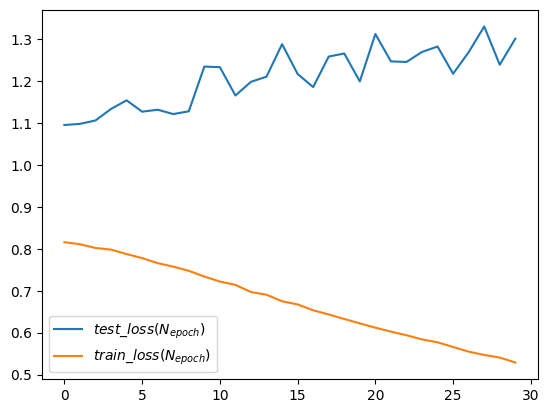

In [ ]:
plt.plot(np.arange(config.num_epochs),test_losses, label = '$test\_loss(N_{epoch})$')
plt.plot(np.arange(config.num_epochs),train_losses, label = '$train\_loss(N_{epoch})$')
#plt.yscale('log')
plt.legend(loc = 'best')
plt.savefig('loss.pdf')

#Trying to interpret results

In [ ]:
from PIL import Image
import cv2

def get_LAB(image_l, image_ab):
    image_lab = np.zeros((224, 224, 3))
    image_lab[:, :, 0] = image_l
    image_lab[:, :, 1:] = image_ab
    image_lab = image_lab.astype("uint8")
    image_rgb = cv2.cvtColor(image_lab, cv2.COLOR_LAB2RGB)
    image_rgb = Image.fromarray(image_rgb)
    return image_rgb

# Let's look on dataset

In [ ]:
#fig, ax = plt.subplots(nrows=150, ncols=1,figsize=(8,400), \
#                       sharey=True, sharex=True)
#for k in range(150):
#  ax[k].imshow(get_LAB(train_dataset.X[77+k].numpy(),train_Y[k+77].numpy()))

# And results

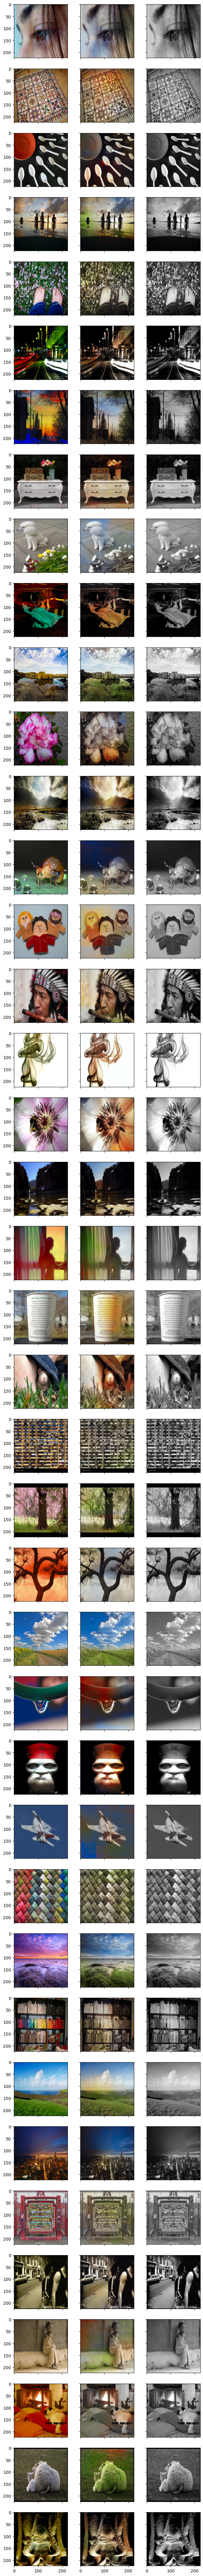

In [ ]:
  fig, ax = plt.subplots(nrows=40, ncols=3,figsize=(8,110), \
                        sharey=True, sharex=True)



  for k in range(40):
    ax[k,2].imshow(test_dataset.X[77+k,0,:,:], cmap='gray', vmin=0, vmax=256)
    ax[k,1].imshow(get_LAB((test_dataset.X[k+77]).numpy(),((D_Y.to(device = 'cuda')*model(torch.unsqueeze((test_dataset.X[k+77]-E_X)/D_X,0).to(device = 'cuda',\
            dtype=torch.float32))+E_Y.to(device = 'cuda')).squeeze().transpose(0,2).transpose(0,1).to(device = 'cpu').detach()).numpy()))
    ax[k,0].imshow(get_LAB(test_dataset.X[77+k].numpy(),test_Y[k+77].numpy()))

  fig.savefig('results.pdf')